This notebook is derived from 04_DE_by_plasmid.ipynb. The purpose is to generate plots with dual guides side by side in a single panel.

In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(Signac)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library(combinat)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
}))
options(timeout=100)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

### Load Seurat file

In [6]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = FALSE)
seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [7]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [8]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

### Load guide df

In [9]:
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
head(df_guide)

,gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD13,CD13-1a,CD13-1b,ANPEP,tss,targeting,ANPEP,Control TSS
2,CD55,CD55-1a,CD55-1b,CD55,tss,targeting,CD55,Control TSS
3,CD73,CD73-1a,CD73-1b,NT5E,tss,targeting,NT5E,Control TSS
4,FUBP1,FUBP1-1a,FUBP1-1b,FUBP1,tss,targeting,FUBP1,Control TSS
5,C15orf40,C15orf40-1a,C15orf40-1b,C15orf40,tss,targeting,C15orf40,Control TSS
6,MAFF,MAFF-1a,MAFF-1b,MAFF,tss,targeting,MAFF,Control TSS


## FeaturePlot singlet & doublet

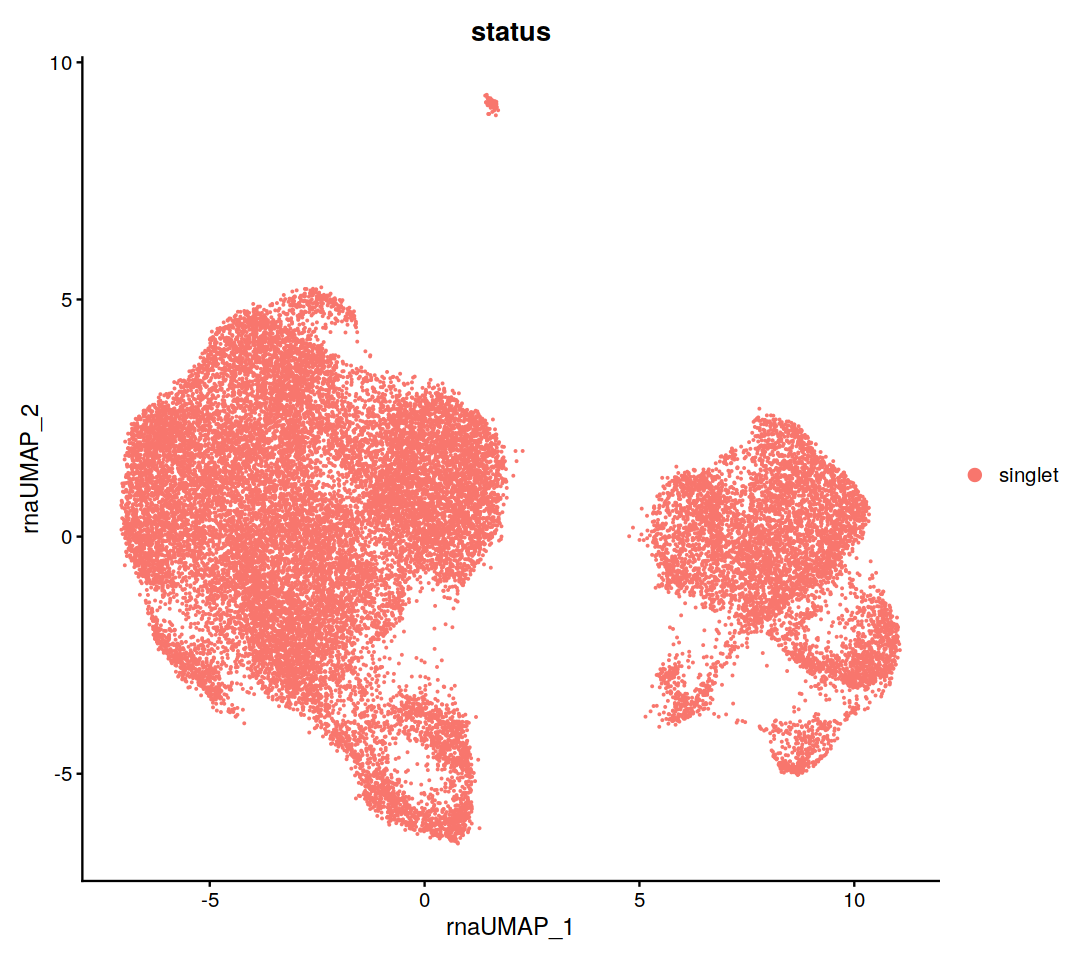

In [10]:
options(repr.plot.width=9, repr.plot.height=8)
DimPlot(seurat_combined, group.by='status')

# Differential expression

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
perturbed_cells_by_guide <- get_all_perturbed_cells_by_guide(seurat_libs, df_thresholds) 
length(perturbed_cells_by_guide[[3]])

[1] 796

In [13]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE1-1b" "NTCE2-1a" "NTCE2-1b" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a"
[8] "NTCE4-1b"

In [14]:
# This function is not necessary. Using mark_target_pos_neg()
# Mark cells that are positive for given guides as target_positive, all others as target_negative
mark_plasmid_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
    all_cells = Cells(seurat_obj)
    perturbed_cells = c()
    dummy_perturbed = c()
    
    for(guide in guides) {
        dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
        perturbed_cells = union(perturbed_cells, dummy_perturbed)    
        #cat(guide," ", length(perturbed_cells), "\n")
    }

    unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
    Idents(seurat_obj) <- "plasmid_negative"
    seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "plasmid_positive") 

    if(print_counts) {
        n_gplus   = length(perturbed_cells)
        n_gminus = length(unperturbed_cells)    
        cat(blue("Plasmid+ =",n_gplus, "; Plasmid- =", n_gminus, "\n"))
    }
    
    seurat_obj
}


### Applications

Find all unperturbed cells: these are the cells with either no guides or only NT guides

In [15]:
select_targeting_guides = df_guide$class == 'targeting'
df_targeting  = df_guide[select_targeting_guides, ]
targeting_guides = c(df_targeting$guide1, df_targeting$guide2)
seurat_rna <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, targeting_guides)
unperturbed_cells <- Cells(subset(seurat_rna, idents='target_negative'))

CD13-1a   868 
CD55-1a   1606 
CD73-1a   2290 
FUBP1-1a   2891 
C15orf40-1a   3558 
MAFF-1a   4041 
FTH1-1a   4476 
FTH1-2a   6507 
PLIN3-1a   7041 
PLIN3-2a   7444 
TKT-1a   7796 
TKT-2a   8268 
LGALS3-1a   8738 
LGALS3-2a   9138 
CSTB-1a   9612 
CSTB-2a   10022 
CTSB-1a   10462 
CTSB-2a   10825 
KLF6-1a   11178 
KLF6-2a   11536 
DE1-1a   11846 
DE1-2a   12178 
DE2-1a   12178 
DE2-2a   12529 
DE3-1a   12864 
DE3-2a   13173 
DE4-1a   13678 
DE4-2a   13896 
DE5-1a   14184 
DE5-2a   14485 
DE6-1a   14722 
DE6-2a   15248 
DE7-1a   15509 
DE7-2a   15709 
DE8-1a   15952 
DE8-2a   16196 
DE9-1a   16420 
DE9-2a   16420 
DE10-1a   16564 
DE10-2a   16760 
DE11-1a   16969 
DE11-2a   17142 
DE12-1a   17298 
DE12-2a   17445 
DE13-1a   17615 
DE13-2a   17747 
DE14-1a   17904 
DE14-2a   18065 
DE15-1a   18224 
DE15-2a   18391 
DE16-1a   18531 
DE16-2a   18531 
DE17-1a   18653 
DE17-2a   18776 
CD13-1b   18791 
CD55-1b   18803 
CD73-1b   18813 
FUBP1-1b   18825 
C15orf40-1b   18842 
MAFF-1b   18851 


# <font color='yellow'> DE for all Targeting Guide pairs </font> 

Load the neighbors of the targets first

In [16]:
library("rlist")
neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/neighbors_list.rds")


Attaching package: 'rlist'


The following object is masked from 'package:S4Vectors':

    List




In [17]:
count_idents <- function(seurat_obj, idents) {
    length(Cells(subset(seurat_obj, idents = idents)))
}

In [18]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
df_targeting = filter(df_guide, class=='targeting')
#df_targeting = filter(df_guide, subclass=='ckd_de')
df_de = NULL
test_use = "LR" #"MAST" #"wilcox" 
genes_to_skip = c("DE5", "CD55", "CSTB")
genes_to_skip = c()
lfc_threshold = 0.03

for(i in 1:nrow(df_targeting)) {
    target = df_targeting[i, 'alias']
    target_subclass = df_targeting[i, 'subclass']
    gene_or_rsid = df_targeting[i, 'gene_or_rsid']

    if(target %in% genes_to_skip){
        cat(red("Skipping", target, "\n"))
        next
    }

    neighbors = neighbors_list[[gene_or_rsid]]
    guides_on_plasmid = unlist(as.list(t(df_targeting[i, c('guide1', 'guide2')])))
    cat(blue(target,":"), paste(guides_on_plasmid, collapse=","),"\n")
    seurat_dummy <- mark_target_pos_neg(
        seurat_rna,        
        perturbed_cells_by_guide, 
        guides_on_plasmid,
        print_counts = T,
        pos_label = "plasmid_positive",
        neg_label = "plasmid_negative"
    )

    if("plasmid_positive" %in% levels((Idents(seurat_dummy)))) {
        markers <- FindMarkers(
            object = seurat_dummy,
            features = neighbors,
            slot = "data",
            ident.1 = 'plasmid_positive',
            ident.2 = 'plasmid_negative',
            test.use = test_use,
            logfc.threshold = lfc_threshold,
            only.pos = FALSE, 
            verbose = FALSE
        )
        # latent.vars = c("library", "donor"),
        # latent.vars = c('library') 
        if(nrow(markers) == 0) {
            cat(red("No DE genes", target,  "\n"))
            next
        } 
        markers$de_gene = rownames(markers)
        markers$target = target
        markers$subclass = target_subclass
        markers$plasmid = gsub("a", "", guides_on_plasmid[[1]])
        markers$label = df_targeting[i, 'label']
        rownames(markers) <- NULL
        df_de = rbind(df_de, markers)
    } else {
        cat(red("No cells found:"), paste(guides_on_plasmid, collapse=","),"\n")
    }
}

ANPEP : CD13-1a,CD13-1b 
CD13-1a   868 
CD13-1b   1162 
Guide+ = 1162 ; Guide- = 25979 
CD55 : CD55-1a,CD55-1b 
CD55-1a   796 
CD55-1b   1081 
Guide+ = 1081 ; Guide- = 26060 
NT5E : CD73-1a,CD73-1b 
CD73-1a   758 
CD73-1b   1021 
Guide+ = 1021 ; Guide- = 26120 
FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   710 
FUBP1-1b   926 
Guide+ = 926 ; Guide- = 26215 
C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   823 
C15orf40-1b   1077 
Guide+ = 1077 ; Guide- = 26064 
MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   665 
MAFF-1b   871 
Guide+ = 871 ; Guide- = 26270 
FTH1 : FTH1-1a,FTH1-1b 
FTH1-1a   624 
FTH1-1b   840 
Guide+ = 840 ; Guide- = 26301 
FTH1 : FTH1-2a,FTH1-2b 
FTH1-2a   2839 
FTH1-2b   2839 
Guide+ = 2839 ; Guide- = 24302 
PLIN3 : PLIN3-1a,PLIN3-1b 
PLIN3-1a   866 
PLIN3-1b   1117 
Guide+ = 1117 ; Guide- = 26024 
PLIN3 : PLIN3-2a,PLIN3-2b 
PLIN3-2a   781 
PLIN3-2b   1050 
Guide+ = 1050 ; Guide- = 26091 
TKT : TKT-1a,TKT-1b 
TKT-1a   674 
TKT-1b   902 
Guide+ = 902 ; Guide- = 26239 
TKT : TKT-2a,TKT-2b

Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


No DE genes DE3 
DE3 : DE3-2a,DE3-2b 
DE3-2a   949 
DE3-2b   1272 
Guide+ = 1272 ; Guide- = 25869 
DE4 : DE4-1a,DE4-1b 
DE4-1a   1622 
DE4-1b   1702 
Guide+ = 1702 ; Guide- = 25439 
DE4 : DE4-2a,DE4-2b 
DE4-2a   772 
DE4-2b   983 
Guide+ = 983 ; Guide- = 26158 
DE5 : DE5-1a,DE5-1b 
DE5-1a   1004 
DE5-1b   1300 
Guide+ = 1300 ; Guide- = 25841 
DE5 : DE5-2a,DE5-2b 
DE5-2a   1054 
DE5-2b   1333 
Guide+ = 1333 ; Guide- = 25808 
DE6 : DE6-1a,DE6-1b 
DE6-1a   896 
DE6-1b   1189 
Guide+ = 1189 ; Guide- = 25952 
DE6 : DE6-2a,DE6-2b 
DE6-2a   1815 
DE6-2b   1826 
Guide+ = 1826 ; Guide- = 25315 
DE7 : DE7-1a,DE7-1b 
DE7-1a   1010 
DE7-1b   1296 
Guide+ = 1296 ; Guide- = 25845 
DE7 : DE7-2a,DE7-2b 
DE7-2a   832 
DE7-2b   1076 
Guide+ = 1076 ; Guide- = 26065 
DE8 : DE8-1a,DE8-1b 
DE8-1a   974 
DE8-1b   1340 
Guide+ = 1340 ; Guide- = 25801 
DE8 : DE8-2a,DE8-2b 
DE8-2a   1124 
DE8-2b   1474 
Guide+ = 1474 ; Guide- = 25667 
DE9 : DE9-1a,DE9-1b 
DE9-1a   934 
DE9-1b   1294 
Guide+ = 1294 ; Guide- = 25

### Correct p-values by total number of comparisons

In [19]:
n_tests = length(flatten(neighbors_list))
print(n_tests)
df_de$p_val_adj_mine =  p.adjust(
    p = df_de$p_val,
    method = "bonferroni",
    n = n_tests
)


[1] 727


Write to file

In [20]:
lfc = gsub("\\.", "_", lfc_threshold)
de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_plasmid_LFC_", lfc, "_UNFILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)

### Filter out spurious hits

In [21]:
# Some genes come up as differentially expressed all the time
# Filter those out, and write to another file
funky_de_genes = c("HMOX1", "AL357507.1", "IFI27", "AL138828.1", "SQSTM1", "PLCG2", "PLIN2", "SAA1", "RARRES2", "CDKN1A")
df_de = filter(df_de, !(de_gene  %in% funky_de_genes))

de_f_name = paste0(secondary_a_path, "/integrated/DE_outputs/DE_genes_by_plasmid_LFC_", lfc, "_FILTERED.tsv")
write.table(df_de, de_f_name, sep="\t", quote = F, row.names = F)

# Inpect DE results

In [22]:
de_f_name
df_de = read.table(de_f_name, sep="\t",  header = T)

[1] "/home/vsevim/prj/1012-ckd/S1/analysis/secondary//integrated/DE_outputs/DE_genes_by_plasmid_LFC_0_03_FILTERED.tsv"

Print top high-confidence hits

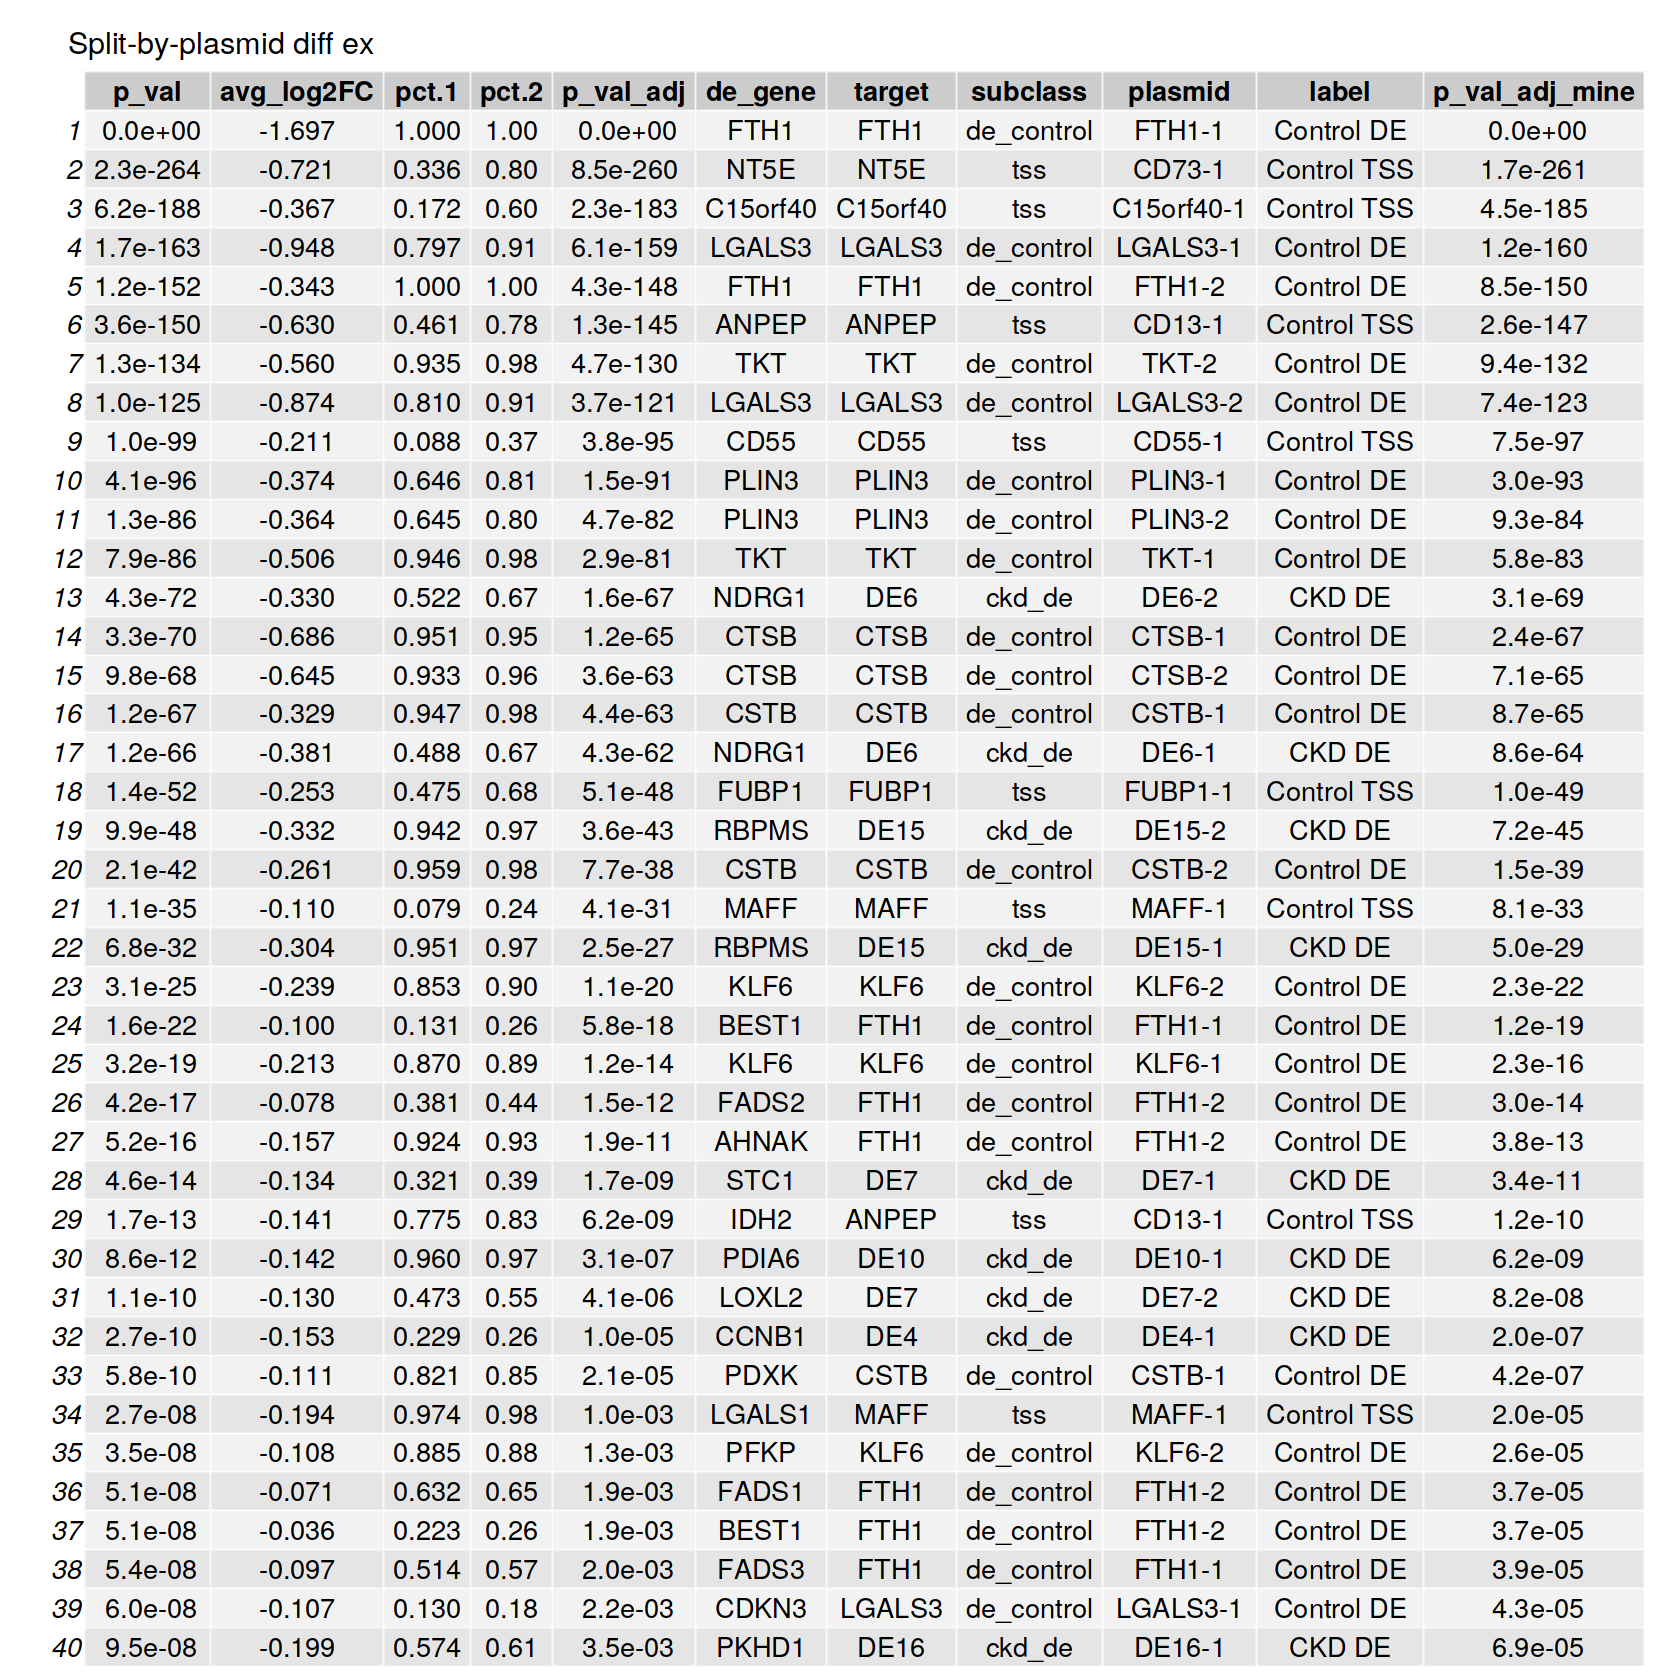

In [23]:
df_top_hits <- df_de %>% filter(avg_log2FC < 0) %>% arrange(p_val_adj) %>% head(40)

tb <- ggtexttable(df_top_hits, theme= ttheme(base_size = 16)) %>% tab_add_title(text = "Split-by-plasmid diff ex", face = "plain", size = 18)
options(repr.plot.width=14, repr.plot.height=14)
print(tb)

# Visualize Knockdowns

## TSS controls

ANPEP : CD13-1a,CD13-1b 
CD13-1a   868 
CD13-1b   1162 
Guide+ = 1162 ; Guide- = 25979 
CD55 : CD55-1a,CD55-1b 
CD55-1a   796 
CD55-1b   1081 
Guide+ = 1081 ; Guide- = 26060 
NT5E : CD73-1a,CD73-1b 
CD73-1a   758 
CD73-1b   1021 
Guide+ = 1021 ; Guide- = 26120 
FUBP1 : FUBP1-1a,FUBP1-1b 
FUBP1-1a   710 
FUBP1-1b   926 
Guide+ = 926 ; Guide- = 26215 
C15orf40 : C15orf40-1a,C15orf40-1b 
C15orf40-1a   823 
C15orf40-1b   1077 
Guide+ = 1077 ; Guide- = 26064 
MAFF : MAFF-1a,MAFF-1b 
MAFF-1a   665 
MAFF-1b   871 
Guide+ = 871 ; Guide- = 26270 


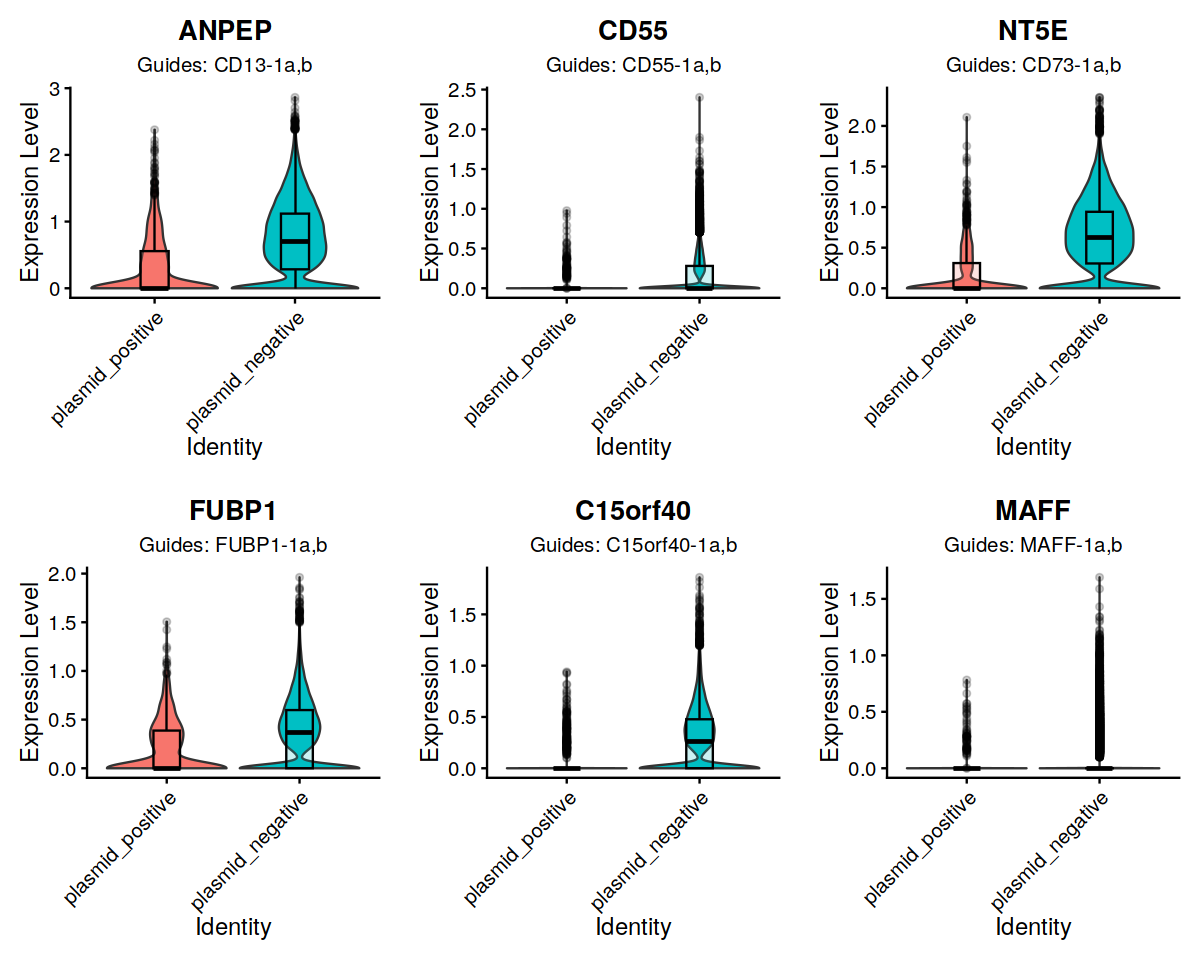

In [24]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
df_tss = filter(df_guide, subclass=='tss')
plots = vlnplot_for_plasmids(seurat_rna, df_tss, perturbed_cells_by_guide)
options(repr.plot.width=10, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=3, nrow = 2)

## DE controls

FTH1 : FTH1-1a,FTH1-1b 
FTH1-1a   624 
FTH1-1b   840 
Guide+ = 840 ; Guide- = 26301 
FTH1 : FTH1-2a,FTH1-2b 
FTH1-2a   2839 
FTH1-2b   2839 
Guide+ = 2839 ; Guide- = 24302 
PLIN3 : PLIN3-1a,PLIN3-1b 
PLIN3-1a   866 
PLIN3-1b   1117 
Guide+ = 1117 ; Guide- = 26024 
PLIN3 : PLIN3-2a,PLIN3-2b 
PLIN3-2a   781 
PLIN3-2b   1050 
Guide+ = 1050 ; Guide- = 26091 
TKT : TKT-1a,TKT-1b 
TKT-1a   674 
TKT-1b   902 
Guide+ = 902 ; Guide- = 26239 
TKT : TKT-2a,TKT-2b 
TKT-2a   873 
TKT-2b   1167 
Guide+ = 1167 ; Guide- = 25974 
LGALS3 : LGALS3-1a,LGALS3-1b 
LGALS3-1a   917 
LGALS3-1b   1171 
Guide+ = 1171 ; Guide- = 25970 
LGALS3 : LGALS3-2a,LGALS3-2b 
LGALS3-2a   811 
LGALS3-2b   1072 
Guide+ = 1072 ; Guide- = 26069 
CSTB : CSTB-1a,CSTB-1b 
CSTB-1a   967 
CSTB-1b   1252 
Guide+ = 1252 ; Guide- = 25889 
CSTB : CSTB-2a,CSTB-2b 
CSTB-2a   931 
CSTB-2b   1217 
Guide+ = 1217 ; Guide- = 25924 
CTSB : CTSB-1a,CTSB-1b 
CTSB-1a   999 
CTSB-1b   1250 
Guide+ = 1250 ; Guide- = 25891 
CTSB : CTSB-2a,CTSB-2b 
CT

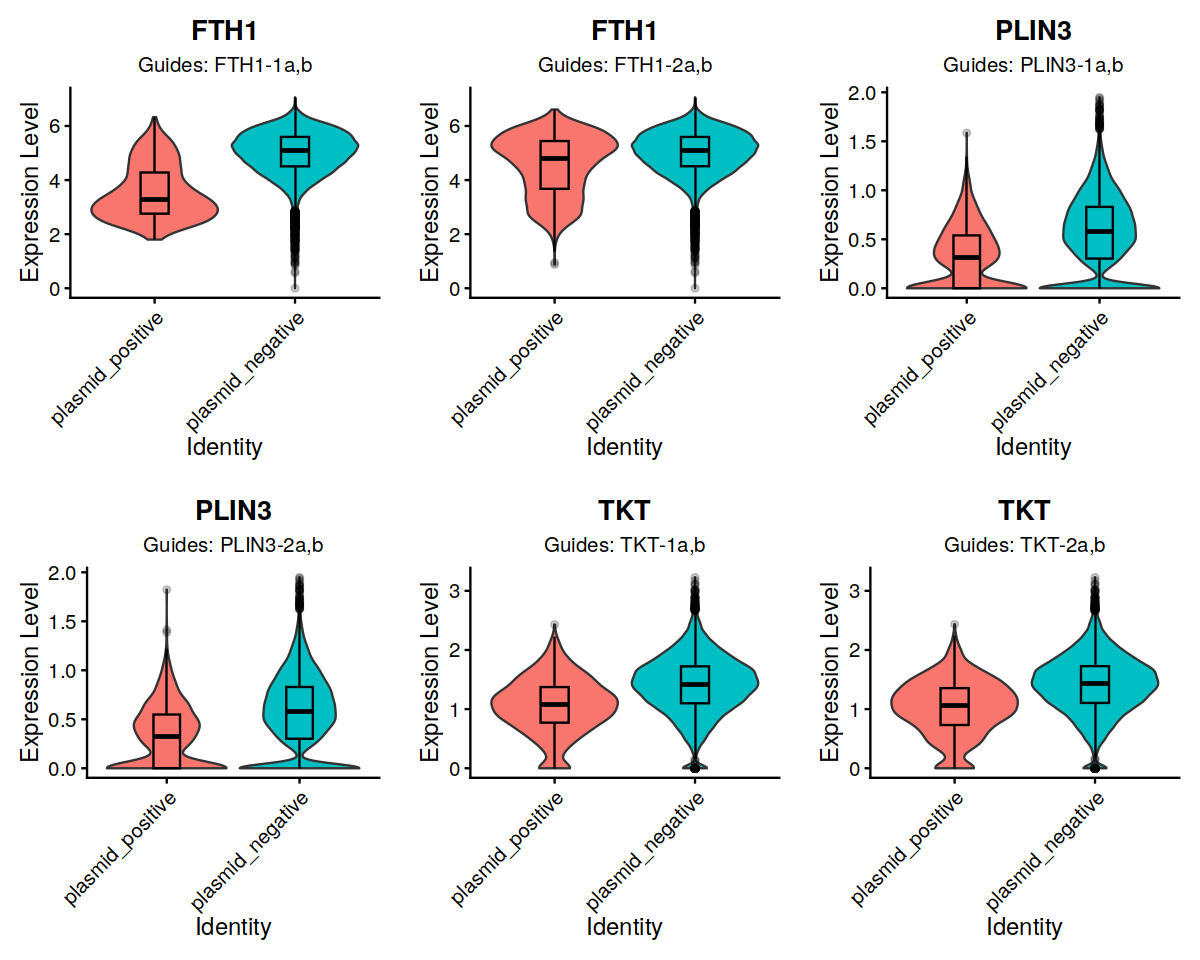

$`1`

$`2`

$`3`

attr(,"class")
[1] "list"      "ggarrange"

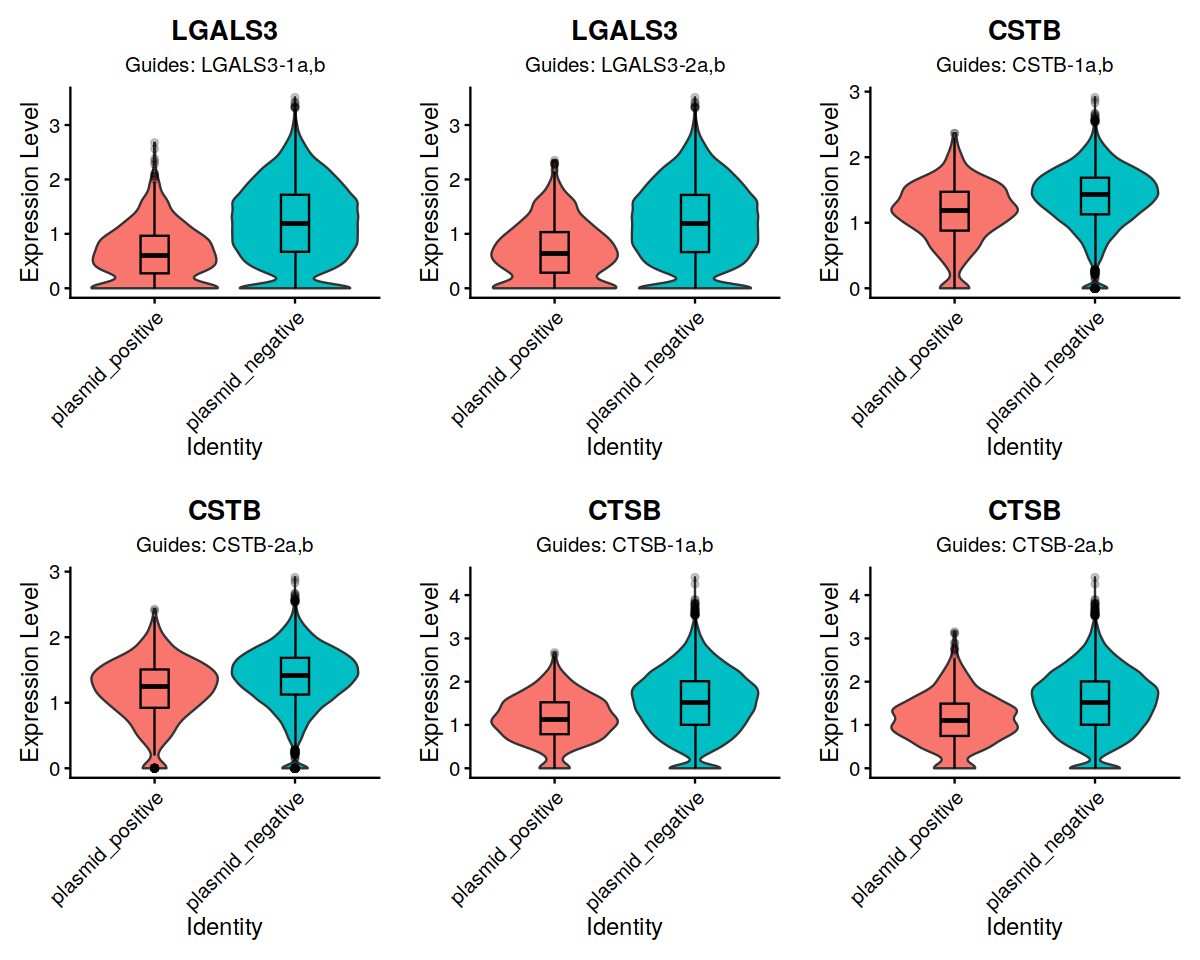

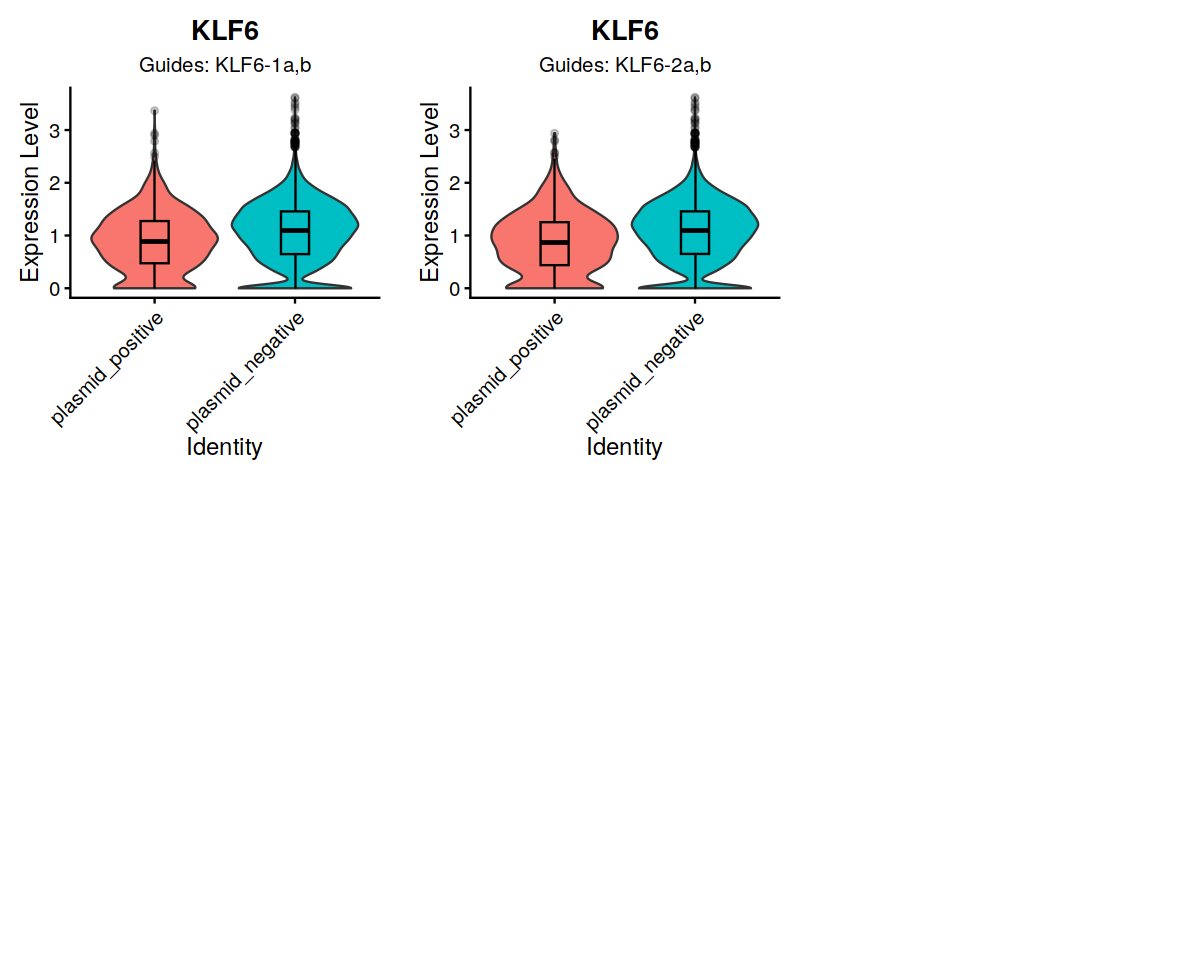

In [25]:
df_de_control = filter(df_guide, subclass=='de_control')
plots = vlnplot_for_plasmids(seurat_rna, df_de_control, perturbed_cells_by_guide)
options(repr.plot.width=10, repr.plot.height=8)
ggarrange(plotlist=plots, ncol=3, nrow = 2)

## CKD DE 

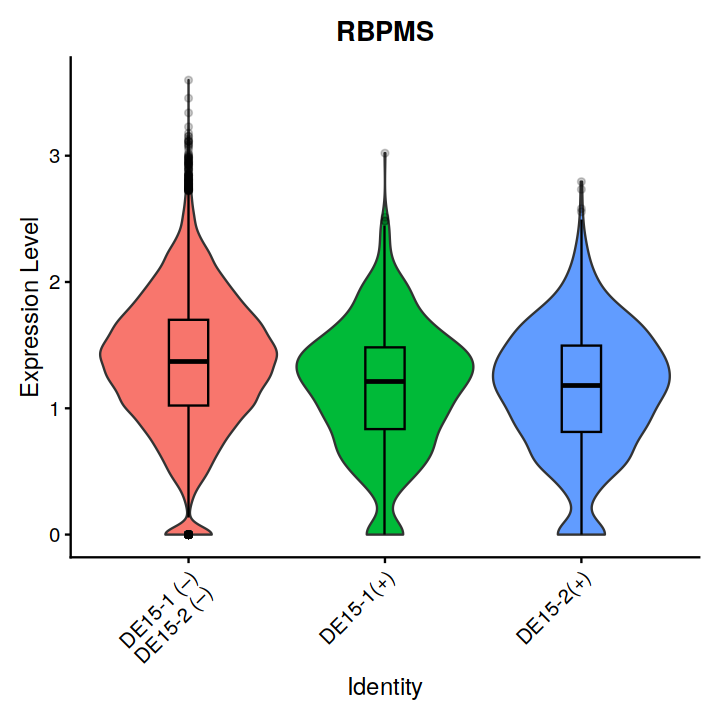

In [41]:
# plasmid_1  = c("DE6-1a", "DE6-1b") 
# plasmid_2  = c("DE6-2a", "DE6-2b")
# plasmid_labels = c("DE6-1", "DE6-2")
# target_gene = "NDRG1"

plasmid_1  = c("DE15-1a", "DE15-1b") 
plasmid_2  = c("DE15-2a", "DE15-2b")
plasmid_labels = c("DE15-1", "DE15-2")
target_gene = "RBPMS"

# plasmid_1  = c("FTH1-1a", "FTH1-1b") 
# plasmid_2  = c("FTH1-2a", "FTH1-2b")
# plasmid_labels = c("FTH1-1", "FTH1-2")
# target_gene = 'FTH1'

plasmid_1_cells = union(
                    perturbed_cells_by_guide[[plasmid_1[[1]]]], 
                    perturbed_cells_by_guide[[plasmid_1[[2]]]]
                )

plasmid_2_cells = union(
                    perturbed_cells_by_guide[[plasmid_2[[1]]]], 
                    perturbed_cells_by_guide[[plasmid_2[[2]]]]
                )

common_cells = intersect(plasmid_1_cells, plasmid_2_cells)
all_cells    = Cells(seurat_rna)
usable_cells = setdiff(all_cells, common_cells)

seurat_dummy = subset(seurat_rna, cells=usable_cells)

Idents(seurat_dummy) <- paste(plasmid_labels[1], "(\u2013)\n", plasmid_labels[2], "(\u2013)")
seurat_dummy <- SetIdent(
    seurat_dummy, 
    cells = plasmid_1_cells, 
    value = paste0(plasmid_labels[1], "(+)")
) 
seurat_dummy <- SetIdent(
    seurat_dummy, 
    cells = plasmid_2_cells, 
    value = paste0(plasmid_labels[2], "(+)")
) 

options(repr.plot.width=6, repr.plot.height=6)
plot <- VlnPlot(
        object = seurat_dummy,
        features = target_gene,
        idents = NULL,
        pt.size = 0,
        sort = T,
        ncol = 1
    ) + 
    geom_boxplot(width=.2, color="black", alpha=0.2) +
    theme(legend.position = 'none')
    
#title = paste0("Guides = ", guides_on_plasmid[[1]][1], ",b")

#plt1 <- ggarrange(plotlist=plots, ncol=3, nrow = 1) 
#plt1 <- annotate_figure(plt1, top = text_grob(title, color = "black", size = 18))  
#print(plt1) 
plot


In [27]:
length(unlist(perturbed_cells_by_guide['DE15-1a']))
sum(seurat_libs[[1]][['sgRNA']]@counts['DE15-1a', ]>=14) +
sum(seurat_libs[[2]][['sgRNA']]@counts['DE15-1a', ]>=10) +
sum(seurat_libs[[3]][['sgRNA']]@counts['DE15-1a', ]>=38) +
sum(seurat_libs[[4]][['sgRNA']]@counts['DE15-1a', ]>=34)
head(tail(df_thresholds,35),3)


[1] 844

[1] 845

,guide,Lib_1,Lib_2,Lib_3,Lib_4
,<chr>,<int>,<int>,<int>,<int>
98,DE15-1b,9,7,19,13
99,DE15-2a,13,9,23,15
100,DE15-2b,17,18,65,43


# Volcano Plot

In [28]:
colors <- ifelse(
    df_de$subclass == 'tss', 'black',
    ifelse(df_de$subclass == 'de_control', 'gray', 'green') 
)

names(colors) <- df_de$label
annotations = df_de$de_gene
plasmid_names = gsub("-", ":", df_de$plasmid)
annotations = paste0(df_de$de_gene, "[",plasmid_names,"]")
#annotations = paste0("expression(", df_de$de_gene, "[",df_de$plasmid,"])")
#annotations = paste0("italic('", df_de$de_gene, "')")
#annotations =  paste0("italic('", df_de$de_gene, "')")

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


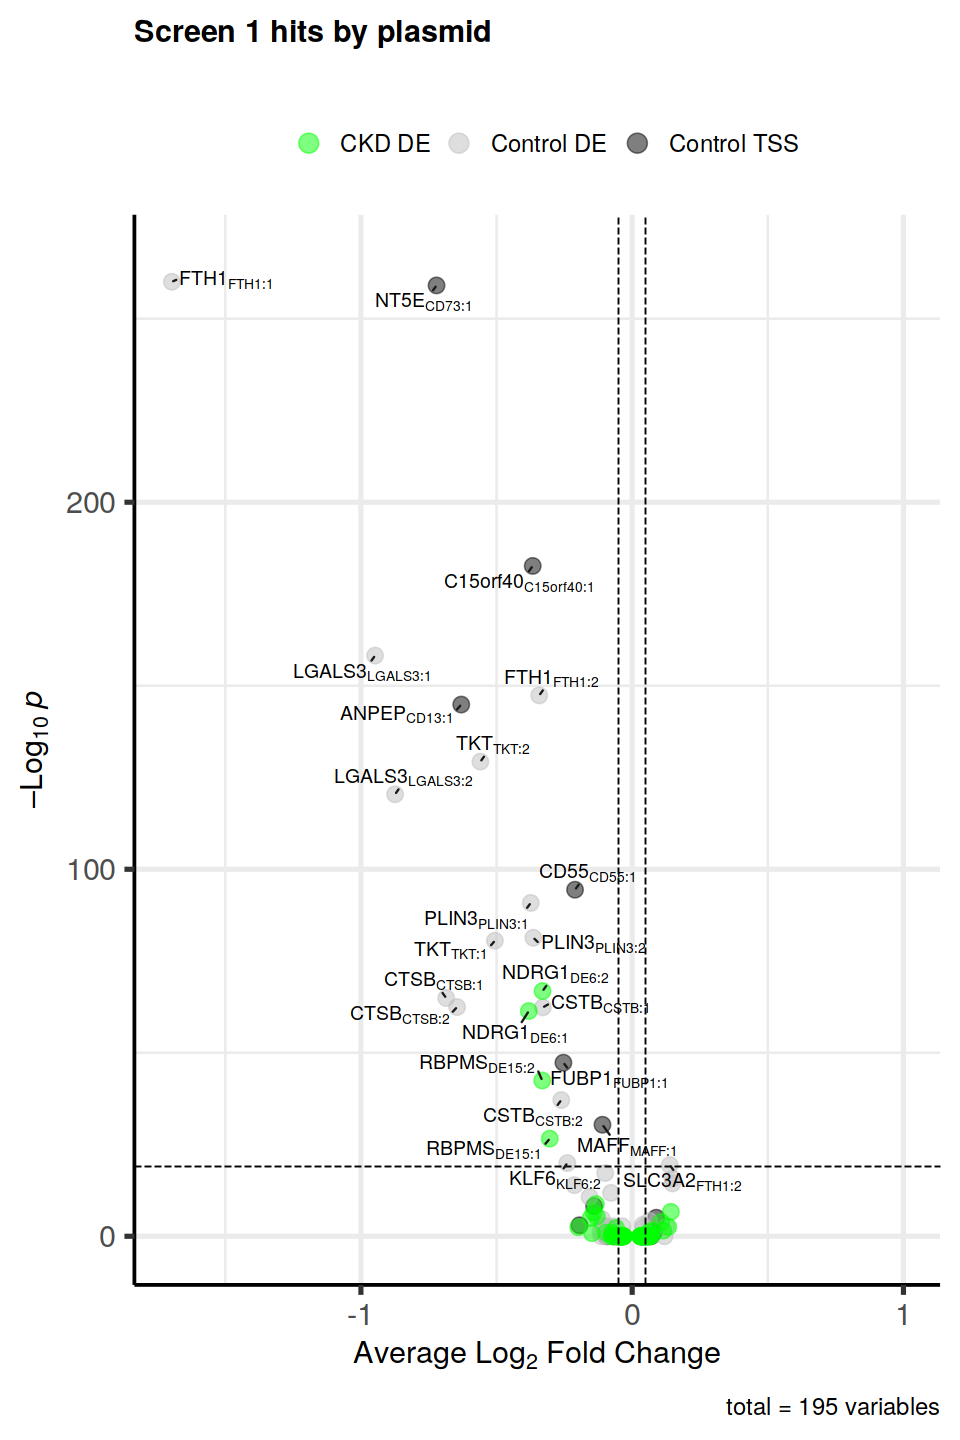

In [29]:
options(repr.plot.width = 8, repr.plot.height = 12)
EnhancedVolcano(df_de, 
                lab = annotations,
                x ="avg_log2FC",
                y ="p_val_adj",
                title = 'Screen 1 hits by plasmid',
                subtitle = '',
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-20,
                FCcutoff = 0.05,
                pointSize = 4.0,
                labSize = 4.0,
                parseLabels = T
            ) +
            xlim(-1.7, 1) +
            xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
            ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

In [40]:
df_de

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,de_gene,target,subclass,plasmid,label,p_val_adj_mine
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
3.6e-150,-0.630,0.461,0.78,1.3e-145,ANPEP,ANPEP,tss,CD13-1,Control TSS,2.6e-147
1.7e-13,-0.141,0.775,0.83,6.2e-09,IDH2,ANPEP,tss,CD13-1,Control TSS,1.2e-10
2.4e-10,0.089,0.675,0.58,8.8e-06,AP3S2,ANPEP,tss,CD13-1,Control TSS,1.7e-07
2.1e-06,0.080,0.584,0.52,7.8e-02,MFGE8,ANPEP,tss,CD13-1,Control TSS,1.6e-03
3.7e-06,0.077,0.826,0.80,1.4e-01,NGRN,ANPEP,tss,CD13-1,Control TSS,2.7e-03
1.2e-04,-0.093,0.803,0.81,1.0e+00,SEMA4B,ANPEP,tss,CD13-1,Control TSS,9.1e-02
4.7e-03,-0.065,0.958,0.96,1.0e+00,CIB1,ANPEP,tss,CD13-1,Control TSS,1.0e+00
5.5e-03,-0.032,0.164,0.17,1.0e+00,FANCI,ANPEP,tss,CD13-1,Control TSS,1.0e+00
1.0e-99,-0.211,0.088,0.37,3.8e-95,CD55,CD55,tss,CD55-1,Control TSS,7.5e-97


# Debug

In [30]:
seurat_dummy = seurat_rna
Idents(seurat_dummy) <- "Entire_assay"
select_targeting = df_targeting$subclass == 'tss' | df_targeting$subclass == 'de_control'
target_genes     = df_targeting[select_targeting,]$alias
AverageExpression(seurat_dummy, features = target_genes, slot = 'counts') %>% data.frame() %>% arrange(desc(all))

The following grouping variables have 1 value and will be ignored: ident

All grouping variables have 1 value only. Computing across all cells.



,all
,<dbl>
FTH1,497.69
CTSB,13.73
CSTB,9.47
TKT,9.43
LGALS3,8.38
KLF6,6.74
ANPEP,4.22
NT5E,3.03
PLIN3,2.52


In [31]:
head(AverageExpression(seurat_dummy, slot = 'counts') %>% data.frame() %>% arrange(desc(all)))

The following grouping variables have 1 value and will be ignored: ident

All grouping variables have 1 value only. Computing across all cells.



,all
,<dbl>
MALAT1,749
FTH1,498
MT2A,495
MT-CO3,472
MT-CO2,443
MT-CO1,359


### more debugging

In [32]:
dummy_pert_a = get_all_perturbed_cells_by_guide(seurat_libs, df_thresholds)
dummy_pert_b = get_perturbed_cells(seurat_combined, df_thresholds)

In [33]:
length(dummy_pert_a$'DE6-1b')
length(dummy_pert_b$'DE6-1b')

[1] 905

[1] 905

In [34]:
length(perturbed_cells_by_guide$'DE6-1b')

[1] 905

In [35]:
nrow(seurat_combined)

[1] 29739

In [36]:
unique(seurat_combined$status)

[1] "singlet"

In [37]:
table(seurat_combined$library)


Lib_1 Lib_2 Lib_3 Lib_4 
 7293  7527  5785  6536 

In [38]:
length(perturbed_cells_by_guide$'FTH1-1a')

[1] 624

In [39]:
length(unlist(perturbed_cells_by_guide))

[1] 108950